In [1]:
# Setup Awal
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset
from torchvision import datasets, models, transforms
from torchvision.transforms import RandAugment
import time
import copy
import numpy as np
from sklearn.metrics import f1_score, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Config
torch.manual_seed(42)
np.random.seed(42)
batch_size = 32
learning_rate = 0.001
num_epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Menggunakan device: {device}")

# Direktori dataset
train_dir = 'C:/Users/ASUS/Downloads/Dataset Random/train'
val_dir = 'C:/Users/ASUS/Downloads/Dataset Random/val'

Menggunakan device: cuda


In [2]:
# Data Preprocessing
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'aug': transforms.Compose([
        RandAugment(num_ops=2, magnitude=9),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

train_dataset_base = datasets.ImageFolder(train_dir, data_transforms['train'])
train_dataset_aug  = datasets.ImageFolder(train_dir, data_transforms['aug'])
train_dataset_concat = ConcatDataset([train_dataset_base, train_dataset_aug])

# Load dataset
image_datasets = {
    'train': train_dataset_concat,
    'val': datasets.ImageFolder(val_dir, data_transforms['val'])
}

dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True, num_workers=4),
    'val': DataLoader(image_datasets['val'], batch_size=batch_size, shuffle=False, num_workers=4)
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
num_classes = image_datasets['train'].datasets[0].classes

print(f"Class names: {num_classes}")
print(f"Jumlah kelas: {len(num_classes)}")
print(f"Ukuran dataset - train : {dataset_sizes['train']}, val: {dataset_sizes['val']}")

Class names: ['Acalypha siamensis Oliv. ex Gage', 'Acalypha wilkesiana Müll.Arg', 'Agathis borneensis Warburg', 'Agave demeesteriana Jacobi', 'Allamanda cathartica L', 'Alocasia macrorrhizos', 'Aloe vera (L.) Burm.f', 'Alstonia angustiloba Miq', 'Alstonia iwahigensis Elmer', 'Amorphophallus paeoniifolius (Dennst.) Nicolson', 'Asystasia gangetica (L.) T.Anderson', 'Borassodendron borneensis J. Dransf', 'Bougainvillea spectabilis', 'Cocos nucifera L', 'Codiaeum variegatum (L.) Rumph. ex A.Juss', 'Cordyline fruticosa (L.) A. Chev', 'Cornus alba L', 'Costus woodsonii Maas', 'Ctenanthe burle-marxii H.Kenn', 'Dillenia sp', 'Diospyros borneensis Hiern', 'Diospyros confertiflora Hiern', 'Dracaena reflexa Lam', 'Dracaena trifasciata (Prain) Mabb', 'Duranta erecta L', 'Eusideroxylon zwageri Teijsm. & Binn', 'Excoecaria cochinchinensis Lour', 'Furcraea foetida (L.) Haw', 'Garcinia mangostana L', 'Grammatophyllum speciosum', 'Hibiscus rosa-sinensis L', 'Hopea pedicellata (Brandis) Symington', 'Hur

In [3]:
# Fungsi Inisialisasi Model
from torchvision.models import ResNet50_Weights, MobileNet_V3_Large_Weights, DenseNet121_Weights, ConvNeXt_Tiny_Weights

def initialize_model(model_name, scenario):
    model = None

    if model_name == 'ResNet50':
        model = models.resnet50(weights='IMAGENET1K_V1')
        if scenario == 'no_hidden':
            model.fc = nn.Linear(model.fc.in_features, len(num_classes))
        else:
            model.fc = nn.Sequential(
                nn.Linear(model.fc.in_features, 512),
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(512, len(num_classes))
            )
        # Freeze semua layer kecuali fc
        for param in model.parameters():
            param.requires_grad = False
        for param in model.fc.parameters():
            param.requires_grad = True

    elif model_name == 'DenseNet121':
        model = models.densenet121(weights='IMAGENET1K_V1')
        if scenario == 'no_hidden':
            model.classifier = nn.Linear(model.classifier.in_features, len(num_classes))
        else:
            model.classifier = nn.Sequential(
                nn.Linear(model.classifier.in_features, 512),
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(512, len(num_classes))
            )
        # Freeze semua layer kecuali classifier
        for param in model.parameters():
            param.requires_grad = False
        for param in model.classifier.parameters():
            param.requires_grad = True
                
    elif model_name == 'MobileNetV3':
        model = models.mobilenet_v3_large(weights='IMAGENET1K_V1')
        if scenario == 'no_hidden':
            model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, len(num_classes))
        else:
            model.classifier[-1] = nn.Sequential(
                nn.Linear(model.classifier[-1].in_features, 512),
                nn.Hardswish(),
                nn.Dropout(0.5),
                nn.Linear(512, len(num_classes))
            )
        # Freeze semua layer kecuali classifier
        for param in model.parameters():
            param.requires_grad = False
        for param in model.classifier.parameters():
            param.requires_grad = True

    elif model_name == 'ConvNeXt':
        model = models.convnext_tiny(weights='IMAGENET1K_V1')
        if scenario == 'no_hidden':
            model.classifier = nn.Sequential(
                nn.Flatten(1),
                nn.LayerNorm([model.classifier[-1].in_features], eps=1e-6),
                nn.Linear(model.classifier[-1].in_features, len(num_classes))
            )
        else:
            model.classifier = nn.Sequential(
                nn.Flatten(1),
                nn.LayerNorm([model.classifier[-1].in_features], eps=1e-6),
                nn.Linear(model.classifier[-1].in_features, 512),
                nn.GELU(),
                nn.Dropout(0.5),
                nn.Linear(512, len(num_classes))
            )
        # Freeze semua layer kecuali classifier
        for param in model.parameters():
            param.requires_grad = False
        for param in model.classifier.parameters():
            param.requires_grad = True

    return model.to(device)

In [4]:
# Fungsi Train&Val
def train_model(model, model_name, scenario):
    print(f'\n=== Model: {model_name} | Skenario: {scenario} ===\n')
    since = time.time()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    history = {
        'train_loss': [], 'train_acc': [], 'train_f1': [],
        'val_loss': [], 'val_acc': [], 'val_f1': []
    }

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_f1 = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1} / {num_epochs}')
        print('-' * 10)
        eptm = time.time()
        
        # Training Phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        train_preds, train_targets = [], []

        for inputs, labels in dataloaders['train']:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (preds == labels).sum().item()
            
            train_preds.extend(preds.cpu().numpy())
            train_targets.extend(labels.cpu().numpy())
            
        # Hitung semua metrik
        epoch_train_loss = running_loss / len(image_datasets['train'])
        epoch_train_acc = 100 * correct_train / total_train
        epoch_train_f1 = f1_score(train_targets, train_preds, average='macro')

        # Validation Phase
        model.eval()
        val_running_loss = 0.0
        correct_val = 0
        total_val = 0
        val_preds, val_targets = [], []

        with torch.no_grad():
            for inputs, labels in dataloaders['val']:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)
                
                _, preds = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (preds == labels).sum().item()
                
                val_preds.extend(preds.cpu().numpy())
                val_targets.extend(labels.cpu().numpy())

        # Hitung semua metrik
        epoch_val_loss = val_running_loss / len(image_datasets['val'])
        epoch_val_acc = 100 * correct_val / total_val
        epoch_val_f1 = f1_score(val_targets, val_preds, average='macro')

        # Update history
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)
        history['train_f1'].append(epoch_train_f1)
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)
        history['val_f1'].append(epoch_val_f1)

        # Simpan model terbaik
        if epoch_val_acc > best_acc:
            best_acc = epoch_val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
        if epoch_val_f1 > best_f1:
            best_f1 = epoch_val_f1
        
        epoch_time = time.time() - eptm
        print(f'Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f} F1: {epoch_train_f1:.4f} | '
              f'Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}% F1: {epoch_val_f1:.4f} | '
              f'Epoch time: {epoch_time // 60:.0f}m {epoch_time % 60:.0f}s\n')
        
    time_elapsed = time.time() - since
    print(f'Training {model_name} {scenario} complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
    print(f'Best val F1: {best_f1:4f}\n')
    visualize_training(history)

    # Save model
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), f'C:/Users/ASUS/Coding/Jupiter/PRTA/{model_name}_{scenario}.pth')

    return {
        'model_name': model_name,
        'scenario': scenario,
        'train_time': time_elapsed,
        'history': history
    }


def visualize_training(history):
    plt.figure(figsize=(15, 5))

    # Plot loss
    plt.subplot(1, 3, 1)
    plt.plot(history['train_loss'], label='train')
    plt.plot(history['val_loss'], label='val')
    plt.title('Loss over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 3, 2)
    plt.plot(history['train_acc'], label='train')
    plt.plot(history['val_acc'], label='val')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot F1-score
    plt.subplot(1, 3, 3)
    plt.plot(history['val_f1'], label='val')
    plt.title('Validation F1-score over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('F1-score')
    plt.legend()

    plt.tight_layout()
    plt.show()

    
# Menyimpan hasil training
results_training = []


=== Model: ResNet50 | Skenario: no_hidden ===

Epoch 1 / 50
----------
Train Loss: 2.0074 Acc: 54.7756 F1: 0.5451 | Val Loss: 0.6648 Acc: 86.4839% F1: 0.8601 | Epoch time: 1m 18s

Epoch 2 / 50
----------
Train Loss: 0.9267 Acc: 77.1795 F1: 0.7706 | Val Loss: 0.4379 Acc: 88.8408% F1: 0.8843 | Epoch time: 1m 16s

Epoch 3 / 50
----------
Train Loss: 0.7448 Acc: 80.3205 F1: 0.8026 | Val Loss: 0.3416 Acc: 90.2838% F1: 0.8998 | Epoch time: 1m 17s

Epoch 4 / 50
----------
Train Loss: 0.6307 Acc: 83.3173 F1: 0.8331 | Val Loss: 0.2851 Acc: 92.2078% F1: 0.9198 | Epoch time: 1m 17s

Epoch 5 / 50
----------
Train Loss: 0.5734 Acc: 84.5353 F1: 0.8449 | Val Loss: 0.3037 Acc: 90.9572% F1: 0.9093 | Epoch time: 1m 17s

Epoch 6 / 50
----------
Train Loss: 0.5397 Acc: 85.0481 F1: 0.8505 | Val Loss: 0.2368 Acc: 93.4103% F1: 0.9332 | Epoch time: 1m 17s

Epoch 7 / 50
----------
Train Loss: 0.5470 Acc: 84.6154 F1: 0.8456 | Val Loss: 0.2290 Acc: 93.6027% F1: 0.9356 | Epoch time: 1m 17s

Epoch 8 / 50
--------

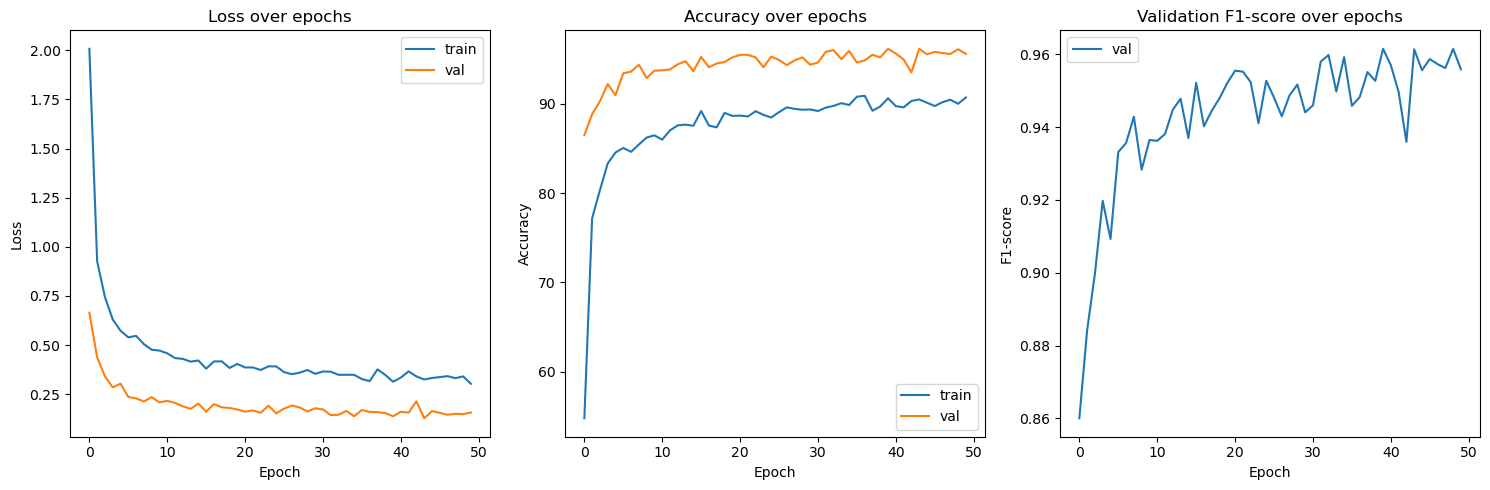


=== Model: ResNet50 | Skenario: with_hidden ===

Epoch 1 / 50
----------
Train Loss: 2.9223 Acc: 26.8429 F1: 0.2573 | Val Loss: 1.3128 Acc: 74.5551% F1: 0.7291 | Epoch time: 1m 16s

Epoch 2 / 50
----------
Train Loss: 1.7252 Acc: 52.5321 F1: 0.5146 | Val Loss: 0.7082 Acc: 83.8384% F1: 0.8309 | Epoch time: 1m 17s

Epoch 3 / 50
----------
Train Loss: 1.3765 Acc: 61.6506 F1: 0.6096 | Val Loss: 0.5311 Acc: 86.2434% F1: 0.8581 | Epoch time: 1m 16s

Epoch 4 / 50
----------
Train Loss: 1.2457 Acc: 64.4872 F1: 0.6395 | Val Loss: 0.5063 Acc: 87.3978% F1: 0.8744 | Epoch time: 1m 17s

Epoch 5 / 50
----------
Train Loss: 1.1729 Acc: 66.7468 F1: 0.6633 | Val Loss: 0.4144 Acc: 89.9952% F1: 0.8986 | Epoch time: 1m 17s

Epoch 6 / 50
----------
Train Loss: 1.0922 Acc: 68.8301 F1: 0.6844 | Val Loss: 0.3904 Acc: 89.1775% F1: 0.8907 | Epoch time: 1m 17s

Epoch 7 / 50
----------
Train Loss: 1.0458 Acc: 69.4551 F1: 0.6914 | Val Loss: 0.3535 Acc: 90.3800% F1: 0.9036 | Epoch time: 1m 17s

Epoch 8 / 50
------

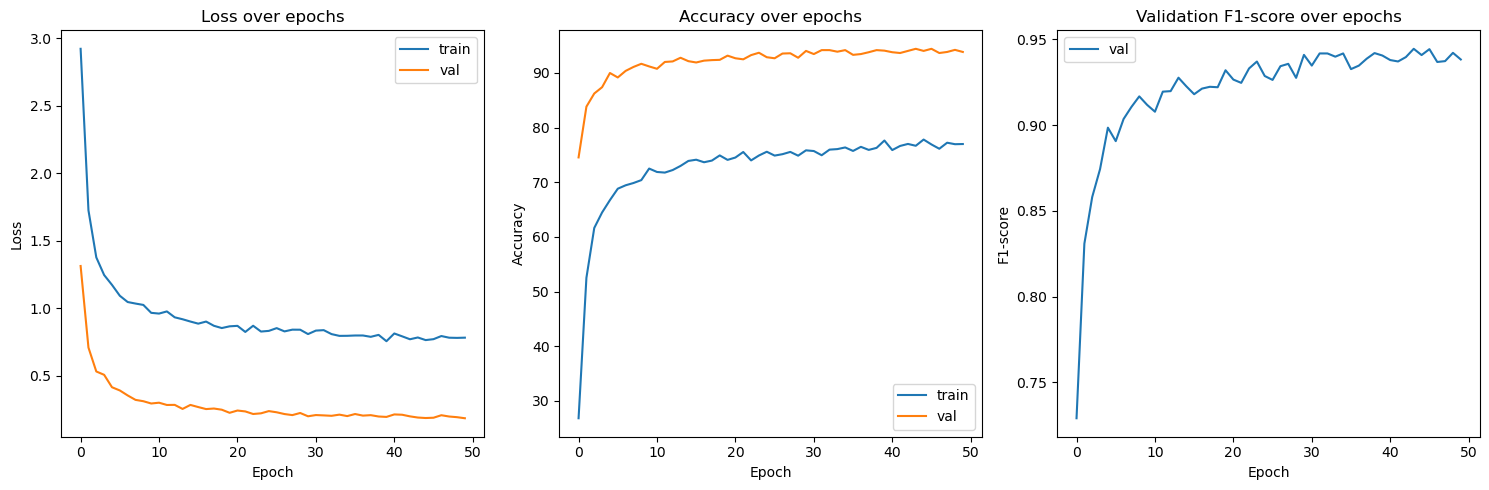

In [5]:
# ResNet50
#Tanpa Hidden Layer
model = initialize_model('ResNet50', 'no_hidden')
res = train_model(model, 'ResNet50', 'no_hidden')
results_training.append(res)

#Dengan Hidden Layer
model = initialize_model('ResNet50', 'with_hidden')
res = train_model(model, 'ResNet50', 'with_hidden')
results_training.append(res)


=== Model: DenseNet121 | Skenario: no_hidden ===

Epoch 1 / 50
----------
Train Loss: 2.4313 Acc: 48.8622 F1: 0.4822 | Val Loss: 1.0670 Acc: 82.7802% F1: 0.8162 | Epoch time: 1m 19s

Epoch 2 / 50
----------
Train Loss: 1.1424 Acc: 76.9551 F1: 0.7671 | Val Loss: 0.6182 Acc: 89.2256% F1: 0.8904 | Epoch time: 1m 18s

Epoch 3 / 50
----------
Train Loss: 0.8590 Acc: 80.5929 F1: 0.8058 | Val Loss: 0.4599 Acc: 90.3800% F1: 0.9005 | Epoch time: 1m 19s

Epoch 4 / 50
----------
Train Loss: 0.7380 Acc: 82.8365 F1: 0.8280 | Val Loss: 0.3781 Acc: 92.4483% F1: 0.9233 | Epoch time: 1m 19s

Epoch 5 / 50
----------
Train Loss: 0.6333 Acc: 85.1442 F1: 0.8511 | Val Loss: 0.3283 Acc: 93.2660% F1: 0.9330 | Epoch time: 1m 19s

Epoch 6 / 50
----------
Train Loss: 0.5855 Acc: 85.6571 F1: 0.8565 | Val Loss: 0.2988 Acc: 93.6989% F1: 0.9364 | Epoch time: 1m 20s

Epoch 7 / 50
----------
Train Loss: 0.5519 Acc: 86.4423 F1: 0.8641 | Val Loss: 0.2628 Acc: 94.4204% F1: 0.9450 | Epoch time: 1m 19s

Epoch 8 / 50
-----

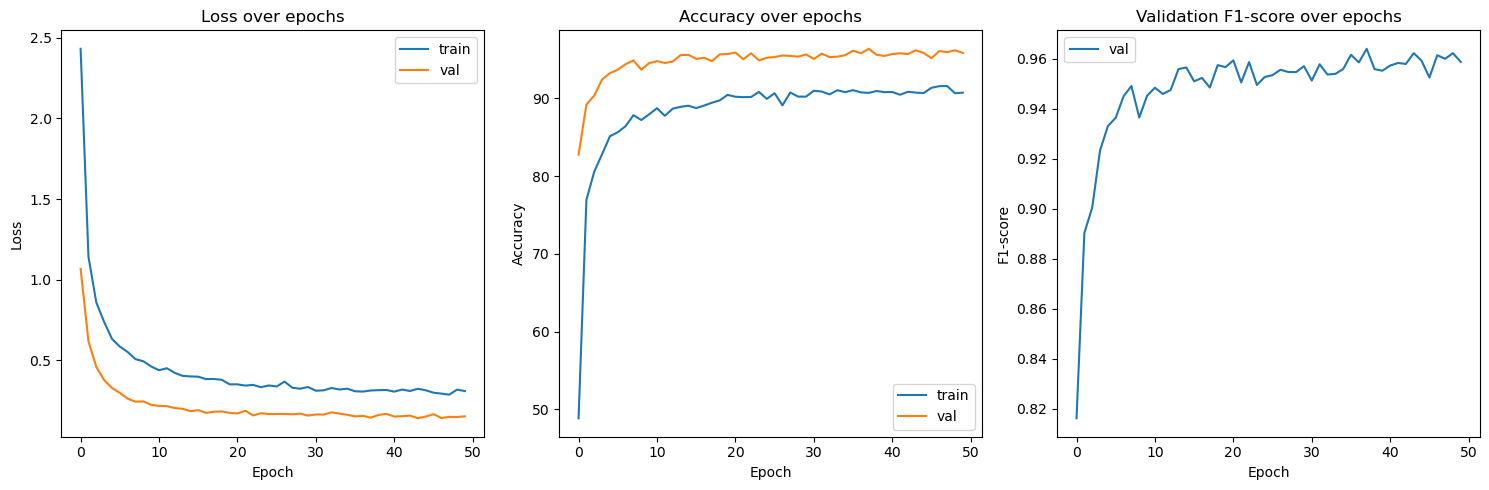


=== Model: DenseNet121 | Skenario: with_hidden ===

Epoch 1 / 50
----------
Train Loss: 2.6666 Acc: 33.8301 F1: 0.3271 | Val Loss: 1.1450 Acc: 75.8538% F1: 0.7373 | Epoch time: 1m 19s

Epoch 2 / 50
----------
Train Loss: 1.3944 Acc: 62.6282 F1: 0.6185 | Val Loss: 0.5951 Acc: 87.1573% F1: 0.8687 | Epoch time: 1m 19s

Epoch 3 / 50
----------
Train Loss: 1.0940 Acc: 69.5353 F1: 0.6917 | Val Loss: 0.4521 Acc: 89.5623% F1: 0.8936 | Epoch time: 1m 19s

Epoch 4 / 50
----------
Train Loss: 0.9463 Acc: 73.6218 F1: 0.7343 | Val Loss: 0.3681 Acc: 91.2458% F1: 0.9120 | Epoch time: 1m 21s

Epoch 5 / 50
----------
Train Loss: 0.8863 Acc: 74.6154 F1: 0.7442 | Val Loss: 0.3326 Acc: 91.2458% F1: 0.9128 | Epoch time: 1m 19s

Epoch 6 / 50
----------
Train Loss: 0.8551 Acc: 75.6891 F1: 0.7554 | Val Loss: 0.2857 Acc: 92.9774% F1: 0.9301 | Epoch time: 1m 19s

Epoch 7 / 50
----------
Train Loss: 0.7832 Acc: 77.4359 F1: 0.7727 | Val Loss: 0.3011 Acc: 92.2559% F1: 0.9208 | Epoch time: 1m 19s

Epoch 8 / 50
---

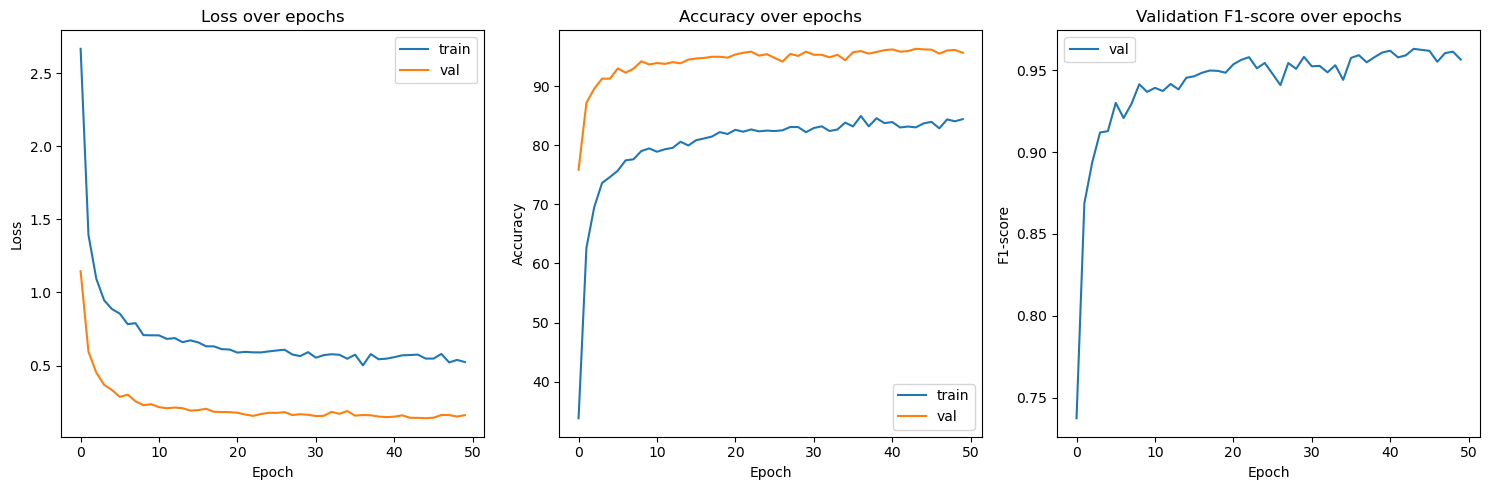

In [6]:
# DenseNet121
#Tanpa Hidden Layer
model = initialize_model('DenseNet121', 'no_hidden')
res = train_model(model, 'DenseNet121', 'no_hidden')
results_training.append(res)

#Dengan Hidden Layer
model = initialize_model('DenseNet121', 'with_hidden')
res = train_model(model, 'DenseNet121', 'with_hidden')
results_training.append(res)


=== Model: MobileNetV3 | Skenario: no_hidden ===

Epoch 1 / 50
----------
Train Loss: 1.3138 Acc: 65.9135 F1: 0.6569 | Val Loss: 0.3751 Acc: 89.1294% F1: 0.8892 | Epoch time: 0m 48s

Epoch 2 / 50
----------
Train Loss: 0.6499 Acc: 81.6827 F1: 0.8161 | Val Loss: 0.2775 Acc: 91.9673% F1: 0.9179 | Epoch time: 0m 48s

Epoch 3 / 50
----------
Train Loss: 0.5357 Acc: 83.8782 F1: 0.8381 | Val Loss: 0.2299 Acc: 93.5065% F1: 0.9362 | Epoch time: 0m 48s

Epoch 4 / 50
----------
Train Loss: 0.4965 Acc: 85.3686 F1: 0.8534 | Val Loss: 0.2093 Acc: 93.7951% F1: 0.9377 | Epoch time: 0m 48s

Epoch 5 / 50
----------
Train Loss: 0.4550 Acc: 86.2019 F1: 0.8619 | Val Loss: 0.1789 Acc: 94.5166% F1: 0.9452 | Epoch time: 0m 48s

Epoch 6 / 50
----------
Train Loss: 0.4271 Acc: 87.3558 F1: 0.8733 | Val Loss: 0.2615 Acc: 92.3040% F1: 0.9241 | Epoch time: 0m 48s

Epoch 7 / 50
----------
Train Loss: 0.4062 Acc: 87.8686 F1: 0.8785 | Val Loss: 0.1649 Acc: 95.5748% F1: 0.9559 | Epoch time: 0m 48s

Epoch 8 / 50
-----

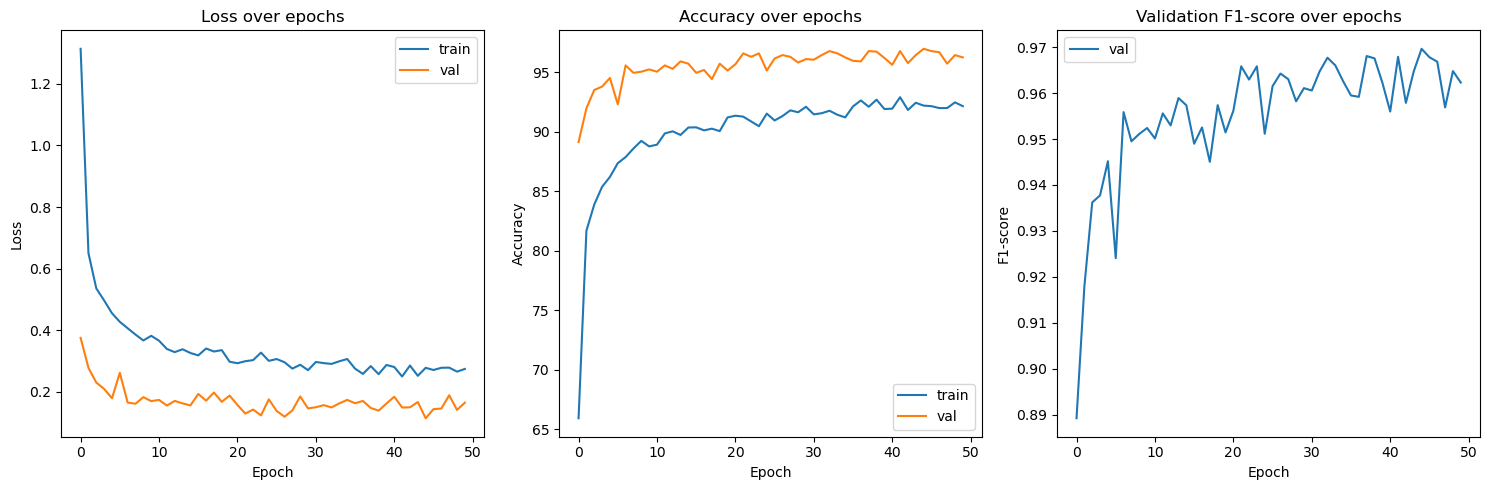


=== Model: MobileNetV3 | Skenario: with_hidden ===

Epoch 1 / 50
----------
Train Loss: 1.5557 Acc: 59.1667 F1: 0.5867 | Val Loss: 0.3843 Acc: 88.7446% F1: 0.8845 | Epoch time: 0m 48s

Epoch 2 / 50
----------
Train Loss: 0.7857 Acc: 77.2436 F1: 0.7711 | Val Loss: 0.3270 Acc: 90.5243% F1: 0.9040 | Epoch time: 0m 48s

Epoch 3 / 50
----------
Train Loss: 0.6664 Acc: 80.2564 F1: 0.8018 | Val Loss: 0.2278 Acc: 93.5546% F1: 0.9352 | Epoch time: 0m 48s

Epoch 4 / 50
----------
Train Loss: 0.5940 Acc: 82.4359 F1: 0.8237 | Val Loss: 0.2489 Acc: 91.9673% F1: 0.9175 | Epoch time: 0m 48s

Epoch 5 / 50
----------
Train Loss: 0.5533 Acc: 83.0288 F1: 0.8298 | Val Loss: 0.1964 Acc: 93.7470% F1: 0.9370 | Epoch time: 0m 48s

Epoch 6 / 50
----------
Train Loss: 0.5275 Acc: 84.4071 F1: 0.8438 | Val Loss: 0.2038 Acc: 94.5166% F1: 0.9450 | Epoch time: 0m 48s

Epoch 7 / 50
----------
Train Loss: 0.5215 Acc: 84.9199 F1: 0.8490 | Val Loss: 0.2222 Acc: 93.9875% F1: 0.9381 | Epoch time: 0m 48s

Epoch 8 / 50
---

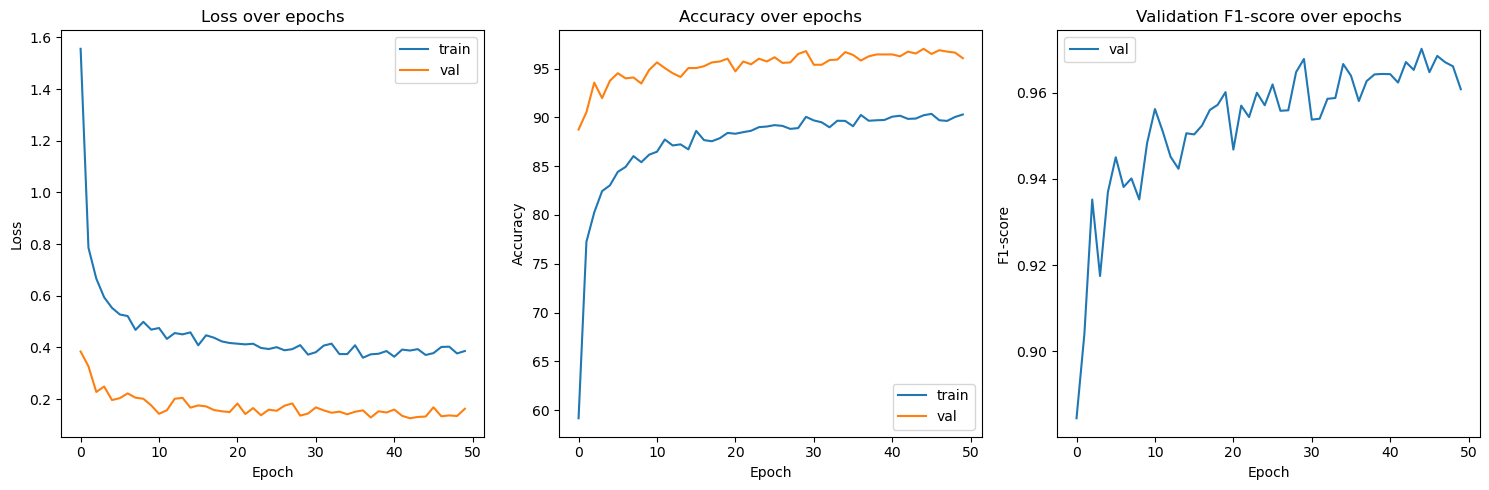

In [7]:
# MobileNetV3 Large
#Tanpa Hidden Layer
model = initialize_model('MobileNetV3', 'no_hidden')
res = train_model(model, 'MobileNetV3', 'no_hidden')
results_training.append(res)

#Dengan Hidden Layer
model = initialize_model('MobileNetV3', 'with_hidden')
res = train_model(model, 'MobileNetV3', 'with_hidden')
results_training.append(res)


=== Model: ConvNeXt | Skenario: no_hidden ===

Epoch 1 / 50
----------
Train Loss: 1.4495 Acc: 69.3750 F1: 0.6917 | Val Loss: 0.4281 Acc: 91.3901% F1: 0.9131 | Epoch time: 1m 36s

Epoch 2 / 50
----------
Train Loss: 0.5478 Acc: 87.3558 F1: 0.8736 | Val Loss: 0.2524 Acc: 94.1318% F1: 0.9411 | Epoch time: 1m 36s

Epoch 3 / 50
----------
Train Loss: 0.3908 Acc: 90.1122 F1: 0.9011 | Val Loss: 0.1988 Acc: 95.0457% F1: 0.9508 | Epoch time: 1m 36s

Epoch 4 / 50
----------
Train Loss: 0.3218 Acc: 92.2596 F1: 0.9227 | Val Loss: 0.1612 Acc: 96.2963% F1: 0.9631 | Epoch time: 1m 36s

Epoch 5 / 50
----------
Train Loss: 0.2793 Acc: 92.8045 F1: 0.9281 | Val Loss: 0.1458 Acc: 96.4887% F1: 0.9647 | Epoch time: 1m 36s

Epoch 6 / 50
----------
Train Loss: 0.2448 Acc: 93.5256 F1: 0.9353 | Val Loss: 0.1263 Acc: 97.1140% F1: 0.9714 | Epoch time: 1m 36s

Epoch 7 / 50
----------
Train Loss: 0.2182 Acc: 94.3590 F1: 0.9436 | Val Loss: 0.1074 Acc: 97.5469% F1: 0.9757 | Epoch time: 1m 37s

Epoch 8 / 50
--------

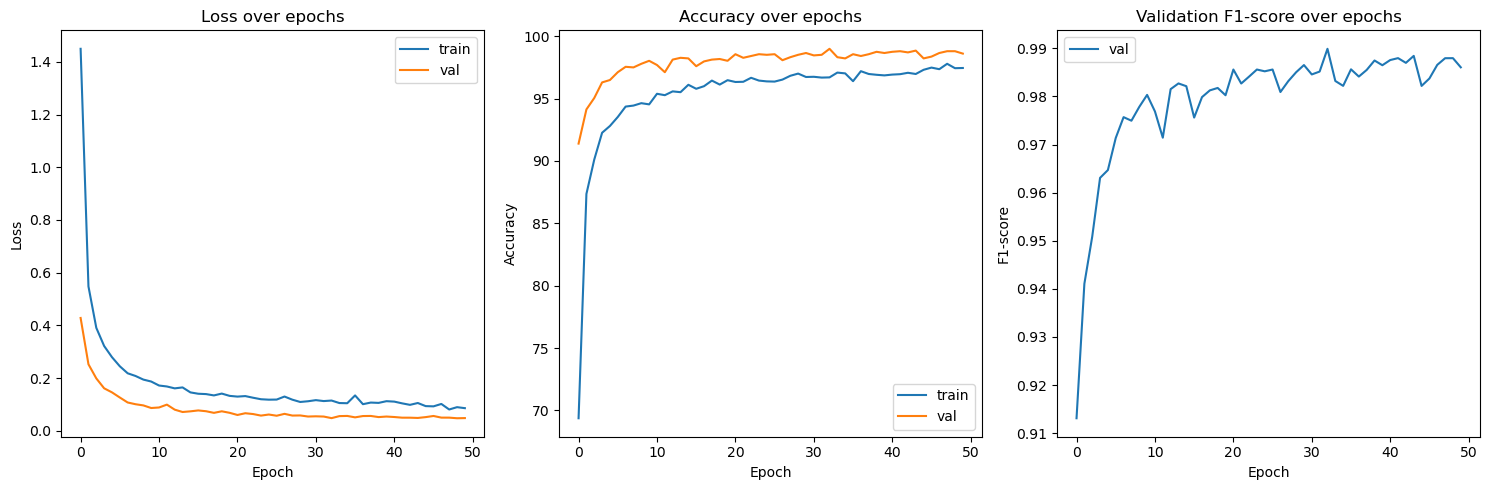


=== Model: ConvNeXt | Skenario: with_hidden ===

Epoch 1 / 50
----------
Train Loss: 1.4103 Acc: 63.3333 F1: 0.6341 | Val Loss: 0.3590 Acc: 89.7547% F1: 0.8968 | Epoch time: 1m 36s

Epoch 2 / 50
----------
Train Loss: 0.5678 Acc: 83.3974 F1: 0.8333 | Val Loss: 0.2330 Acc: 93.0255% F1: 0.9299 | Epoch time: 1m 37s

Epoch 3 / 50
----------
Train Loss: 0.4361 Acc: 87.3558 F1: 0.8734 | Val Loss: 0.1605 Acc: 95.2381% F1: 0.9523 | Epoch time: 1m 38s

Epoch 4 / 50
----------
Train Loss: 0.3587 Acc: 88.7981 F1: 0.8878 | Val Loss: 0.1497 Acc: 95.4786% F1: 0.9557 | Epoch time: 1m 36s

Epoch 5 / 50
----------
Train Loss: 0.3380 Acc: 89.5032 F1: 0.8949 | Val Loss: 0.1278 Acc: 95.9596% F1: 0.9605 | Epoch time: 1m 36s

Epoch 6 / 50
----------
Train Loss: 0.2868 Acc: 91.5705 F1: 0.9156 | Val Loss: 0.1094 Acc: 97.0659% F1: 0.9710 | Epoch time: 1m 36s

Epoch 7 / 50
----------
Train Loss: 0.2769 Acc: 91.6026 F1: 0.9160 | Val Loss: 0.0799 Acc: 97.6431% F1: 0.9765 | Epoch time: 1m 36s

Epoch 8 / 50
------

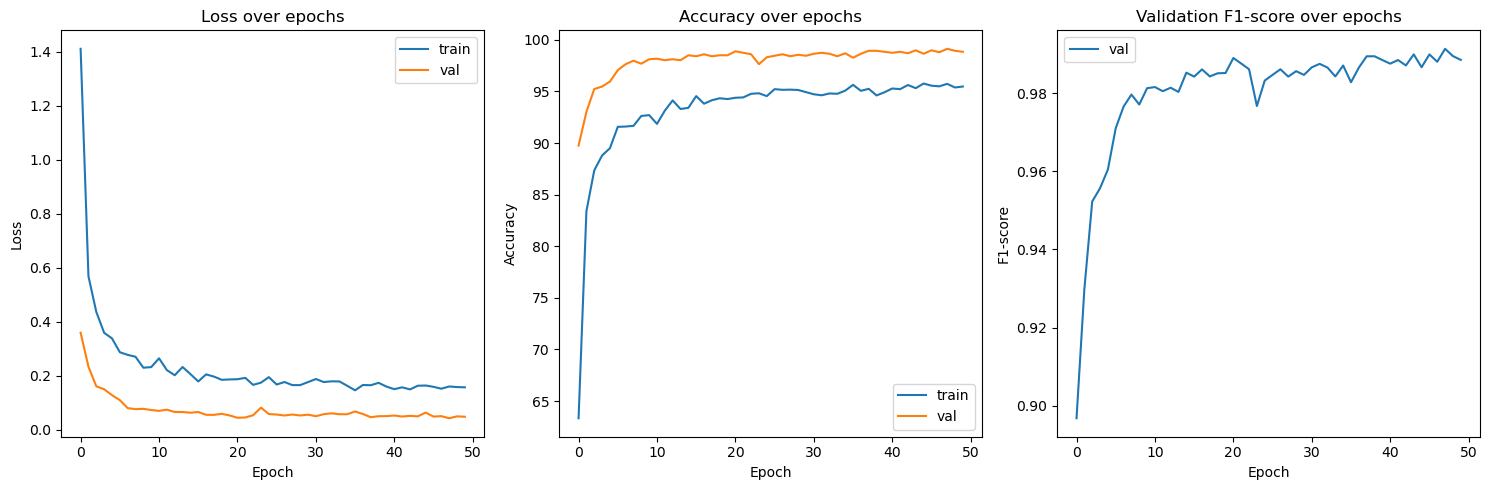

In [8]:
# ConvNeXt Tiny
#Tanpa Hidden Layer
model = initialize_model('ConvNeXt', 'no_hidden')
res = train_model(model, 'ConvNeXt', 'no_hidden')
results_training.append(res)

#Dengan Hidden Layer
model = initialize_model('ConvNeXt', 'with_hidden')
res = train_model(model, 'ConvNeXt', 'with_hidden')
results_training.append(res)

In [9]:
# Simpan hasil train & val
results_training_df = pd.DataFrame(results_training)
results_training_df.to_csv('C:/Users/ASUS/Coding/Jupiter/PRTA/train&val_results.csv', index=False)
print(results_training_df)

    model_name     scenario   train_time  \
0     ResNet50    no_hidden  3830.505871   
1     ResNet50  with_hidden  3831.400132   
2  DenseNet121    no_hidden  3942.061292   
3  DenseNet121  with_hidden  3948.527492   
4  MobileNetV3    no_hidden  2392.503314   
5  MobileNetV3  with_hidden  2394.966484   
6     ConvNeXt    no_hidden  4820.545798   
7     ConvNeXt  with_hidden  4832.236090   

                                             history  
0  {'train_loss': [2.0074339059682993, 0.92671043...  
1  {'train_loss': [2.92226304152073, 1.7252112645...  
2  {'train_loss': [2.4313161752162835, 1.14239678...  
3  {'train_loss': [2.6665831247965497, 1.39443641...  
4  {'train_loss': [1.313806320917912, 0.649918871...  
5  {'train_loss': [1.5556550949047774, 0.78574234...  
6  {'train_loss': [1.4494801678718665, 0.54781465...  
7  {'train_loss': [1.410251897573471, 0.567810468...  


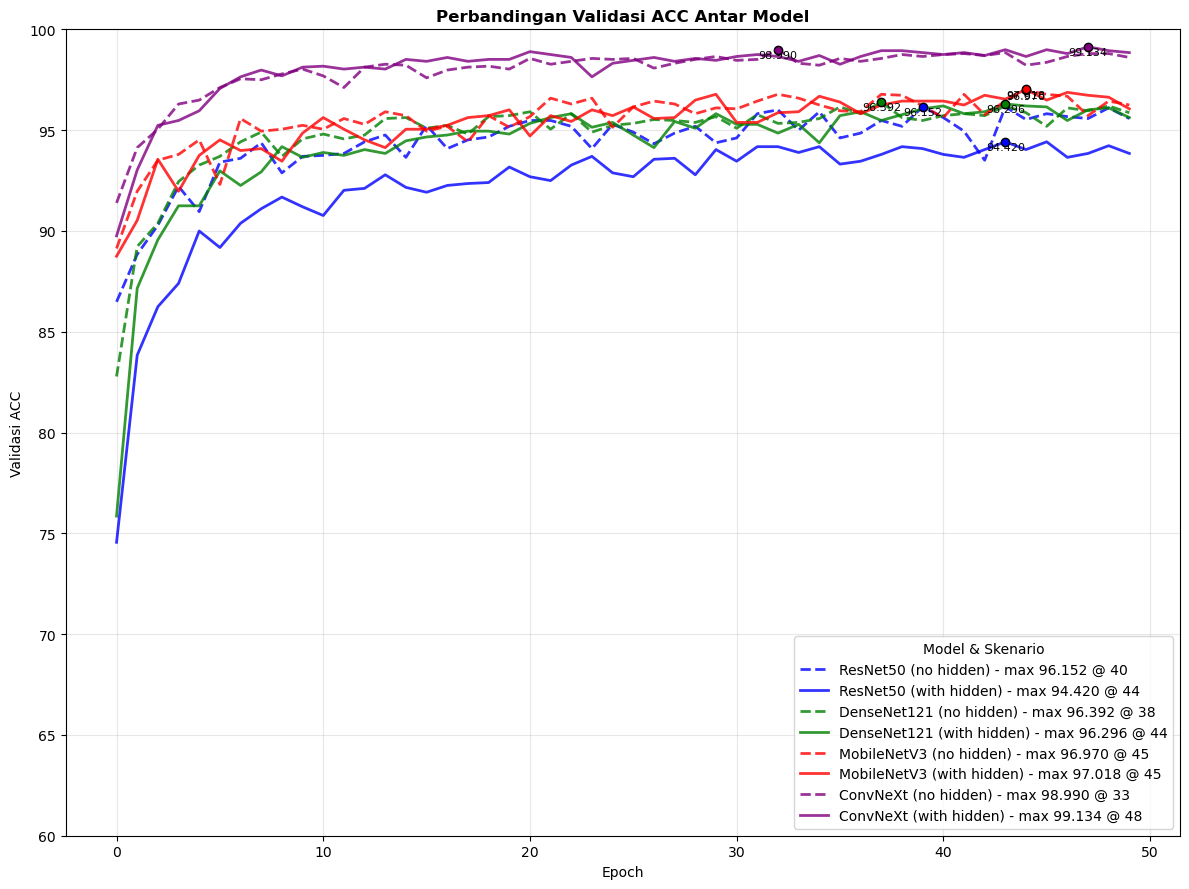

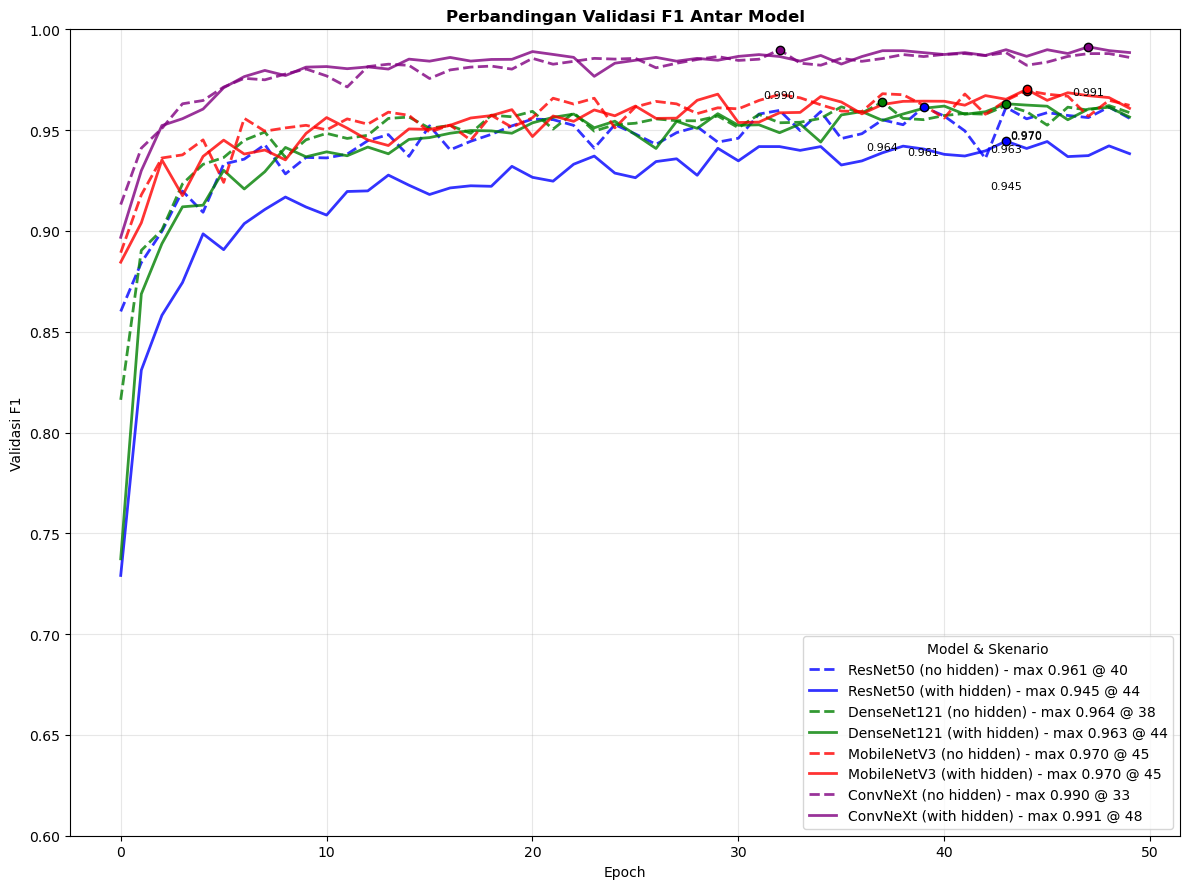

In [10]:
# Multi-Line Chart | Acc & F1 | Val
def plot_metric_comparison(results_training_df, metric='acc'):
    plt.figure(figsize=(12, 9))
    palette = {
        'ResNet50': 'blue',
        'DenseNet121': 'green',
        'MobileNetV3': 'red',
        'ConvNeXt': 'purple'
    }

    styles = {
        'no_hidden': 'dashed',
        'with_hidden': 'solid'
    }

    legend_items = []

    for model in results_training_df['model_name'].unique():
        for scenario in ['no_hidden', 'with_hidden']:
            subset = results_training_df[
                (results_training_df['model_name'] == model) & (results_training_df['scenario'] == scenario)
            ]
            if not subset.empty:
                history = subset.iloc[0]['history']
                val_metric = history[f'val_{metric}']
                best_epoch = max(range(len(val_metric)), key=lambda i: val_metric[i])
                best_value = val_metric[best_epoch]

                label = f"{model} ({scenario.replace('_', ' ')}) - max {best_value:.3f} @ {best_epoch+1}"
                legend_items.append(label)

                plt.plot(
                    val_metric, 
                    linestyle=styles[scenario],
                    color=palette[model],
                    linewidth=2,
                    alpha=0.8,
                    label=label
                )

                # Mark the best point
                plt.scatter(
                    best_epoch, best_value,
                    color=palette[model],
                    edgecolor='black',
                    zorder=5
                )

                # Add value text
                plt.text(
                    best_epoch, best_value - 0.02,
                    f"{best_value:.3f}",
                    ha='center',
                    va='top',
                    fontsize=8,
                    color='black'
                )

    plt.title(f'Perbandingan Validasi {metric.upper()} Antar Model', weight='bold')
    plt.xlabel('Epoch')
    plt.ylabel(f'Validasi {metric.upper()}')
    if max(val_metric) > 1.0:
        plt.ylim(60, 100)
    else :
        plt.ylim(0.6, 1)
    plt.grid(True, alpha=0.3)
    plt.legend(title="Model & Skenario", loc='lower right', frameon=True)
    plt.tight_layout()
    plt.savefig(f'C:/Users/ASUS/Coding/Jupiter/PRTA/val_{metric}_comparison.png', bbox_inches='tight')
    plt.show()

# Plot untuk akurasi
plot_metric_comparison(results_training_df, metric='acc')

# Plot untuk F1-score
plot_metric_comparison(results_training_df, metric='f1')